# Imports

In [24]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures

In [2]:
%load_ext lab_black

# Data

In [3]:
# read in all the words
with open("../data/names.txt", "r") as f:
    words = f.read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [51]:
VOCAB_SZ = len(stoi)
GEN_SEED = 2147483647
RANDOM_SEED = 42
BLOCK_SZ = 3  # context length: how many characters do we take to predict the next one
HIDDEN_DIM = 200
EMB_DIM = 10
BATCH_SZ = 32

In [6]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * BLOCK_SZ
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [7]:
# Split data: 80% training, 10% validation, 10% test
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

# MLP (Bengio Paper)

In [8]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((VOCAB_SZ, EMB_DIM), generator=g)  # Same embedding matrix
W1 = torch.randn((BLOCK_SZ * EMB_DIM, HIDDEN_DIM), generator=g)
b1 = torch.randn(HIDDEN_DIM, generator=g)
W2 = torch.randn((HIDDEN_DIM, VOCAB_SZ), generator=g)
b2 = torch.randn(VOCAB_SZ, generator=g)
parameters = [C, W1, b1, W2, b2]
W1.shape, b1.shape, W2.shape, b2.shape

(torch.Size([30, 200]),
 torch.Size([200]),
 torch.Size([200, 27]),
 torch.Size([27]))

In [9]:
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 10])

In [10]:
# First hidden layer
h = torch.tanh(emb.view(-1, BLOCK_SZ * EMB_DIM) @ W1 + b1)

# Output layer
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

loss = -prob[torch.arange(len(Ytr)), Ytr].log().mean()
loss

tensor(26.0047)

In [11]:
sum(p.nelement() for p in parameters)  # number of parameters in total

11897

In [12]:
for p in parameters:
    p.requires_grad = True

In [15]:
# Picking a good learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (BATCH_SZ,))

    # forward pass
    emb = C[Xtr[ix]]  # (batch_size, block_size, emb_dim)
    h = torch.tanh(emb.view(-1, BLOCK_SZ * EMB_DIM) @ W1 + b1)  # (32, 200)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    # lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

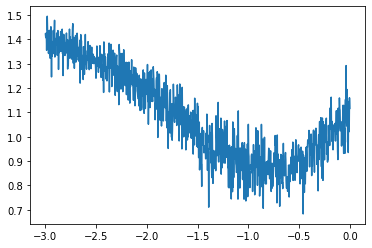

In [16]:
plt.plot(lre, lossi)

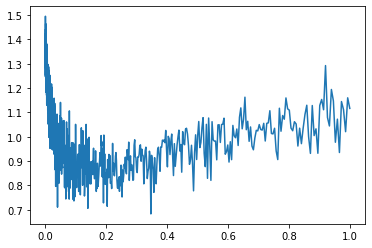

In [17]:
plt.plot(lrs, lossi)

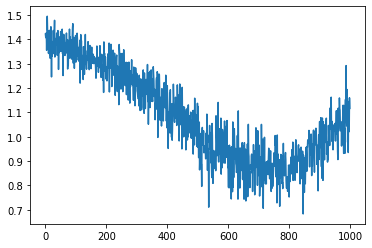

In [18]:
plt.plot(stepi, lossi)

In [19]:
# Train first for 100000 epochs with 0.1 lr
# Then for 1000000 epochs with 0.01 lr

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((VOCAB_SZ, EMB_DIM), generator=g)  # Same embedding matrix
W1 = torch.randn((BLOCK_SZ * EMB_DIM, HIDDEN_DIM), generator=g)
b1 = torch.randn(HIDDEN_DIM, generator=g)
W2 = torch.randn((HIDDEN_DIM, VOCAB_SZ), generator=g)
b2 = torch.randn(VOCAB_SZ, generator=g)
parameters = [C, W1, b1, W2, b2]
emb = C[Xtr]

for p in parameters:
    p.requires_grad = True


for i in range(100_000):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (BATCH_SZ,))

    # forward pass
    emb = C[Xtr[ix]]  # (batch_size, block_size, emb_dim)
    h = torch.tanh(emb.view(-1, BLOCK_SZ * EMB_DIM) @ W1 + b1)  # (32, 200)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

In [20]:
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, BLOCK_SZ * EMB_DIM) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3484, grad_fn=<NllLossBackward0>)

In [21]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, BLOCK_SZ * EMB_DIM) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3771, grad_fn=<NllLossBackward0>)

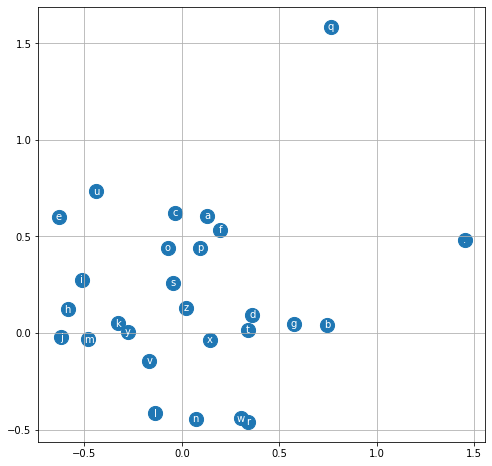

In [22]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

In [23]:
# sample from the model
context = [0] * BLOCK_SZ
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * BLOCK_SZ  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

carline.
toriellin.
mis.
rehim.
skandene.
rahnen.
den.
rhi.
kaqeison.
mari.
chaiim.
kaneigh.
ham.
noin.
quinn.
shonnei.
vin.
isianelle.
jarynix.
kaeliighan.


# Optimizing MLP

1. Initialize weights using kaiming_init
2. Change the weights of the last layer so that we can get the start up loss very similar to 1 / 27, which means all next characters are equally likely
3. Add batch normalization to stabilize training and the stats of each hidden layer

In [45]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # Kaiming initialization
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [46]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [59]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            dim = 0 if x.ndim == 2 else (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [94]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((VOCAB_SZ, EMB_DIM), generator=g)
layers = [
    Linear(EMB_DIM * BLOCK_SZ, HIDDEN_DIM, bias=False),
    BatchNorm1d(HIDDEN_DIM),
    Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False),
    BatchNorm1d(HIDDEN_DIM),
    Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False),
    BatchNorm1d(HIDDEN_DIM),
    Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False),
    BatchNorm1d(HIDDEN_DIM),
    Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False),
    BatchNorm1d(HIDDEN_DIM),
    Tanh(),
    Linear(HIDDEN_DIM, VOCAB_SZ, bias=False),
    BatchNorm1d(VOCAB_SZ),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0  # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

In [95]:
print(sum(p.nelement() for p in parameters))  # number of parameters in total

173724


In [96]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 1e-1 if i < 150_000 else 1e-2  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )
    if i >= 1000:
        break  # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2920


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.88%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.81%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.30%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.97%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.48%


Text(0.5, 1.0, 'activation distribution')

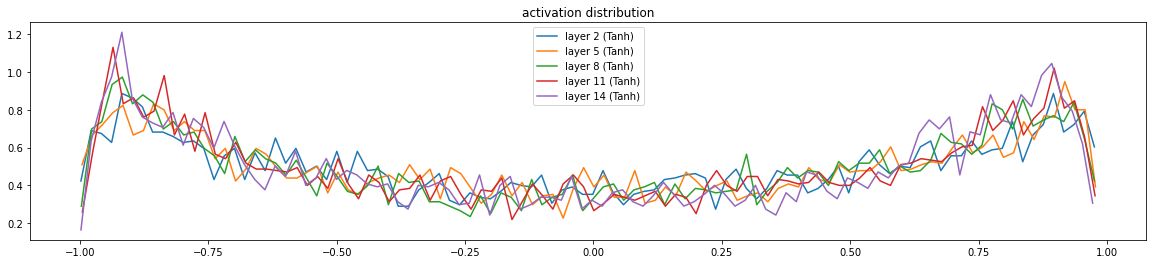

In [97]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.000000, std 1.569563e-03
layer 5 (      Tanh): mean +0.000000, std 1.246896e-03
layer 8 (      Tanh): mean +0.000000, std 1.180020e-03
layer 11 (      Tanh): mean -0.000000, std 1.066129e-03
layer 14 (      Tanh): mean +0.000000, std 1.035778e-03


Text(0.5, 1.0, 'gradient distribution')

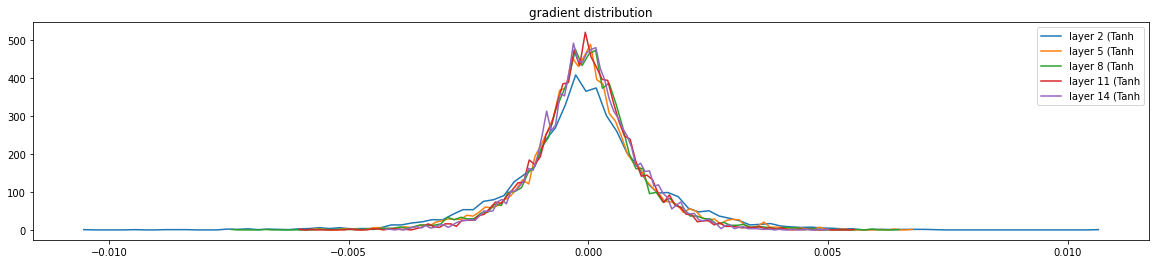

In [98]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean +0.000000 | std 9.382021e-03 | grad:data ratio 9.372659e-03
weight  (30, 200) | mean +0.000056 | std 6.821453e-03 | grad:data ratio 3.642210e-02
weight (200, 200) | mean -0.000015 | std 4.741553e-03 | grad:data ratio 6.589777e-02
weight (200, 200) | mean -0.000012 | std 3.861355e-03 | grad:data ratio 5.398549e-02
weight (200, 200) | mean -0.000005 | std 3.380301e-03 | grad:data ratio 4.713388e-02
weight (200, 200) | mean +0.000011 | std 3.031940e-03 | grad:data ratio 4.259432e-02
weight  (200, 27) | mean -0.000062 | std 8.925302e-03 | grad:data ratio 1.178504e-01


Text(0.5, 1.0, 'weights gradient distribution')

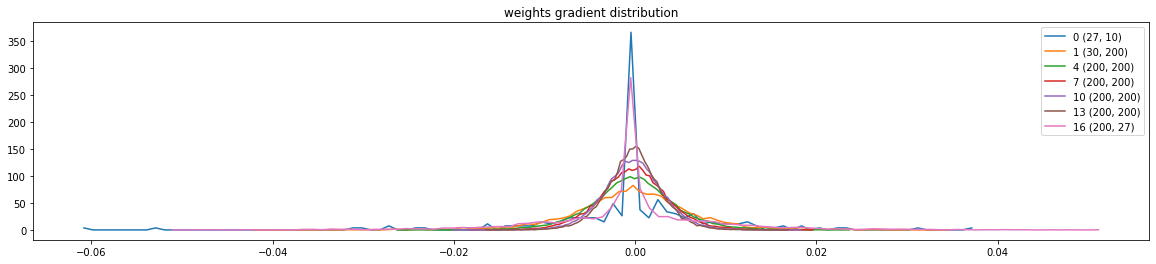

In [99]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")

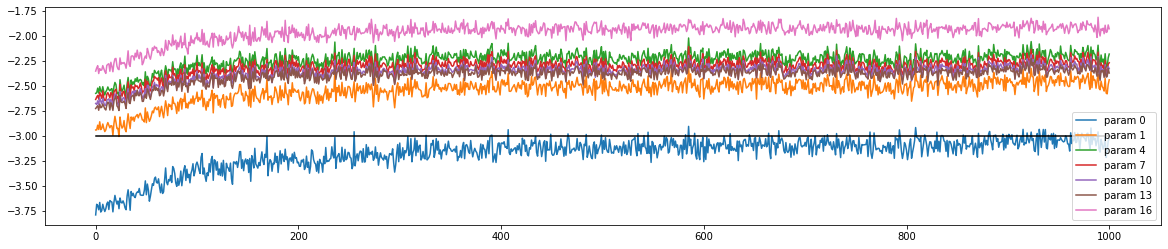

In [100]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [101]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 1e-1 if i < 150_000 else 1e-2  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

      0/ 200000: 2.4063
  10000/ 200000: 2.2878
  20000/ 200000: 2.2580
  30000/ 200000: 2.3528
  40000/ 200000: 2.0275
  50000/ 200000: 1.9067
  60000/ 200000: 2.0802
  70000/ 200000: 1.9114
  80000/ 200000: 1.7915
  90000/ 200000: 1.8163
 100000/ 200000: 1.8236
 110000/ 200000: 1.7711
 120000/ 200000: 1.8871
 130000/ 200000: 1.8479
 140000/ 200000: 1.8383
 150000/ 200000: 2.2528
 160000/ 200000: 1.8769
 170000/ 200000: 2.0685
 180000/ 200000: 2.1659
 190000/ 200000: 1.8527


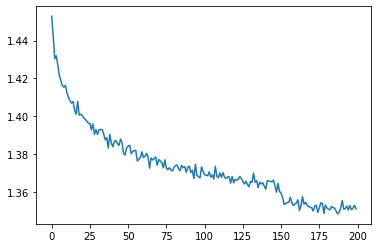

In [102]:
plt.plot(torch.tensor(lossi).view(-1, 1_000).exp().mean(dim=1))

In [103]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False

In [104]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

In [105]:
split_loss("train")
split_loss("val")

train 1.9608372449874878
val 2.0743465423583984


In [106]:
# sample from the model
context = [0] * BLOCK_SZ
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * BLOCK_SZ  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

wothxfej.
woltpmpbpvqwgvlyquhnnthwu.
wowzqpvlwgpgwrcchppqwpsqfxfxqcgwbnvqhbowickwpbdbnvqhandxxcbasouhr.
wowickwpbwbowicgeqfrhrzruqcfvqhvrwxlyncwpbdbwetkffvlnnxxojqhgegphorinslyncwblvfik.
wowzqpvlwgefotynlwfekolyncwes.
wxlyncwpbdbnvqhosawuwges.
wowmwpgoxx.
wuwgwindte.
qoeqhrfrqcafliex.
wowickwpbdwfeka.
wonbwidmphppppppppppppppppppppppppwbpkowickwpbdbowuwges.
wu.
wolynccefvthrlagvlyquhr.
wiwgpgcboxxqhaflicawgwetkfej.
wondgjyqyvvhwgltpxvqqcflegua.
wiwgtt.
wowzqpvlyquhr.
ricchwppmbpitpxdkkkjamu.
wuhktpvlwodyqwidmphpgpbovthrnowickwpbdwfekatbewicegly.
wowxqzgfr.


# MLP with Pytorch

In [42]:
class MLP(nn.Module):
    def __init__(self, vocab_sz, emb_dim, block_sz, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_sz, emb_dim)
        self.hidden = nn.Linear(block_sz * emb_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, vocab_sz)

    def forward(self, x):
        x = self.embedding(x)
        x = F.tanh(self.hidden(x.view(-1, BLOCK_SZ * EMB_DIM)))
        x = self.out(x)
        return x